In [1]:
import numpy as np

In [67]:
class Tensor:
    def __init__ (self, data, requires_grad=False, _children=(), _op='', label=''):
        self.data =  data
        self.requires_grad = requires_grad
        self.grad = 0
        self.grad_fn = None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"tensor(data={self.data}, requires_grad={self.requires_grad})"

    def backward(self, grad_output=None):
        if grad_output is None:
            grad_output = 1.0

        self.grad = grad_output

        if self.grad_fn:
            self.grad_fn.backward(grad_output)
        
    @property
    def dtype(self):
        if isinstance(self.data, np.ndarray):
            return self.data.dtype

        else:
            return np.array(self.data).dtype

    @property
    def shape(self):
        if isinstance(self.data, np.ndarray):
            return self.data.shape
        else:
            return ()
        
    
    def item(self):
        if isinstance(self.data, np.ndarray):
            if self.data.size != 1:
                raise ValueError(f"a Tensor with {self.data.size} elements cannnot converted into scalar")
            return self.data.item()
        else:
            return self.data


    def __add__(self, other):
        if not isinstance(other, Tensor):
            other = Tensor(other)
            
        return Add.apply(self, other)

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        if not isinstance(other, Tensor):
            other = Tensor(other)

        return Add.apply(self, -other)

    def __mul__(self, other):
        if not isinstance(other, Tensor):
            other = Tensor(other)

        return Mul.apply(self, other)

    def __rmul__(self, other):
        return self * other


    def __truediv__(self, other):
        return self * other ** -1
    
    def __pow__(self, other):
        if not isinstance(other, (int, float)):
            raise ValueError(f'Tensor power can only be int or float')

        return Pow.apply(self, other)

In [68]:
class Function:
    @staticmethod
    def forward(ctx, *args):
        raise NotImplementedError

    @staticmethod
    def backward(ctx, grad_output):
        raise NotImplementedError

class Add(Function):
    @staticmethod
    def apply(a, b):
        output = Tensor(a.data + b.data, _children=(a, b), _op='+')
        output.requires_grad = a.requires_grad or b.requires_grad
        output.grad_fn = AddCtx(a, b)
        return output

class AddCtx:
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def backward(self, grad_output):
        if self.a.requires_grad:
            self.a.backward(grad_output * 1.0)
        if self.b.requires_grad:
            self.b.backward(grad_output * 1.0)            

class Mul(Function):
    @staticmethod
    def apply(a, b):
        output = Tensor(a.data * b.data, _children=(a, b), _op='*')
        output.requires_grad = a.requires_grad or b.requires_grad
        output.grad_fn = MulCtx(a, b)
        return output


class MulCtx:
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def backward(self, grad_output):
        if self.a.requires_grad:
            self.a.backward(grad_output * self.b.data)
        if self.b.requires_grad:
            self.b.backward(grad_output * self.a.data)

class Pow(Function):
    @staticmethod
    def apply(a, b):
        output = Tensor(a.data ** b, _children=(a,), _op="**")
        output.requires_grad = a.requires_grad

        output.grad_fn = PowCtx(a, b)
        return output

class PowCtx:
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def backward(self, grad_output):
        if self.a.requires_grad:
            self.a.backward((self.b * self.a.data ** (self.b - 1)) * grad_output)
        

In [69]:
a = Tensor(np.array([3]))

In [5]:
b = Tensor(np.array([3, 4, 5]))

In [6]:
b.item()

ValueError: a Tensor with 3 elements cannnot converted into scalar

In [7]:
a

tensor(data=[3], requires_grad=False)

In [8]:
a.requires_grad = True

In [9]:
a

tensor(data=[3], requires_grad=True)

In [10]:
a.item()

3

In [11]:
a.dtype

dtype('int64')

In [12]:
import torch 
t = torch.tensor(5)
t.shape

torch.Size([])

In [13]:
c = Tensor(3)

In [14]:
c.shape

()

In [15]:
a.shape

(1,)

In [16]:
a = Tensor(2)
b = Tensor(3)

a.requires_grad = True
b.requires_grad = True

In [17]:
a+b

tensor(data=5, requires_grad=True)

In [18]:
z = a + b

In [19]:
z.backward()

In [20]:
z

tensor(data=5, requires_grad=True)

In [21]:
a.grad

1.0

In [22]:
b.grad

1.0

In [23]:
x = Tensor(np.array([1, 2]))
x.shape

(2,)

In [24]:
y = Tensor(np.array([3, 4]))
y.shape

(2,)

In [25]:
z = x + y
z

tensor(data=[4 6], requires_grad=False)

In [26]:
!pip install graphviz 

In [11]:
from graphviz import Digraph

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = set(), []

    def build(v):
        if v not in nodes:
            nodes.add(v)

            label = f"{v.label} | data: {v.data:.4f}"
            dot.node(str(id(v)), label = "{ %s | data %.4f | grad %.4f }" % (v.label, v.data, v.grad), shape='record')

            for child in v._prev:
                edges.append((child, v))
                build(child)

    build(root)

    for u, v in edges:
        dot.edge(str(id(u)), str(id(v)), label=v._op)

    return dot


In [48]:
a = Tensor(1, label='a')
b = Tensor(2, label='b')

a.requires_grad = True
b.requires_grad = True

y = a + b

y.backward()

y.label = 'y'


x = Tensor(4, label='x')

z = y + x

z.backward()

z.label = 'z'


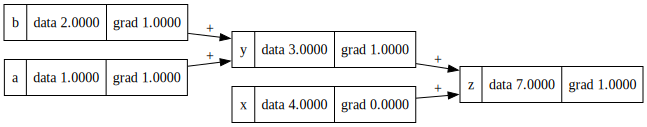

In [49]:
draw_dot(z)

In [55]:
m = y * x

x.requires_grad = True

m.backward()

<p> m = y * x </p>
<p> m = (a + b) * x </p>
<p>m = ax + bx</p>

<p>dm/dm = 1  ==> (1)</p>


<p>dm/dx = y  ==> (3)</p>
<p>dm/dy = x ==> (4)</p>

<p>dm/da = x ==> (4)</p>
<p>dm/db = x ==> (4)</p>


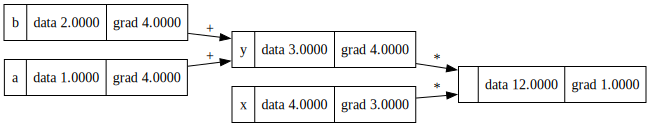

In [56]:
draw_dot(m)

In [61]:
a = Tensor(2, requires_grad = True, label='a')
b = Tensor(3, requires_grad = True, label = 'b')

y = a ** 4 + b
y.label = 'y'
y.backward()

<p>y = a ** 4 + b</p>

<p>dy/dy = 1</p>

<p>dy/da = 4a ** 3 = 4(2) **3 = 32</p>
<p> dy/db = 1 </p>

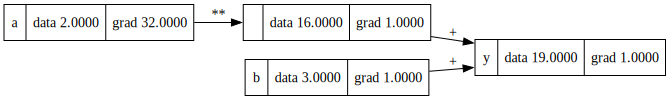

In [12]:
draw_dot(y)

In [13]:
x = Tensor(4, requires_grad=True, label='x')

z = (y ** 2) * x
z.backward()

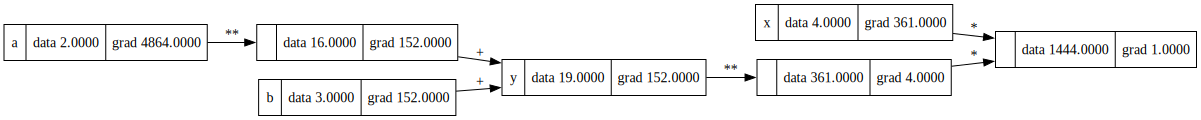

In [14]:
draw_dot(z)

In [ ]:
# z = ((a**4 +b) ** 2 ) * x
# dz/da = x * (2 *(a**4 + b)*2 (4a**3) )

In [22]:
s = Tensor(np.array([1, 2, 4]) ,label='s', requires_grad=True)

r = s ** 2
r.backward()

In [23]:
r
s.grad

array([2., 4., 8.])

In [64]:
y = a-b

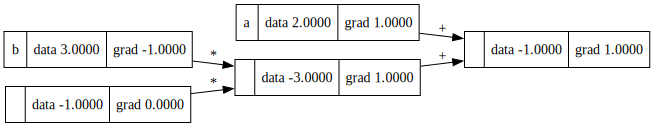

In [65]:
y.backward()
draw_dot(y)

In [72]:
c = Tensor(np.array([2, 4]), label='c', requires_grad = True)
d = Tensor(2, label='d', requires_grad = True)

e = c / d
e.backward()

In [77]:
print(c.grad, d.grad)

0.5 [-0.5 -1. ]
